This implementation makes following assumptions:

1. Data is present in a folder named `Amharic NER`
2. Data is split into three files, namely `train.txt`, `dev.txt` and `test.txt`.
3. Each file has only two columns with first row as the column names.
4. The column names are `Text` and `Label`.
5. Each row is separated by a single space `' '`.

Configure the code/data if any assumption is not matched.

## Imports

Install and import all the dependencies

In [ ]:
!pip install seqeval accelerate datasets transformers

In [ ]:
import numpy as np
import pandas as pd

from tqdm.auto import tqdm

import sklearn

from datasets import load_dataset, load_metric, ClassLabel, Dataset, DatasetDict

from transformers import Trainer
from transformers import AutoTokenizer
from transformers import get_scheduler
from transformers import TrainingArguments
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification

import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader

from accelerate import Accelerator

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

##Data Initialization

### Training set

In [ ]:
train_df = pd.read_csv('./Amharic NER/train.txt', sep=" ", header='infer', on_bad_lines='skip')
print('Shape of train data: ', train_df.shape)
print(train_df.columns)
train_df.head()

Shape of train data:  (57781, 2)
Index(['Text', 'Label'], dtype='object')


,Text,Label
0,ገለ,O
1,መሰኻኽር,O
2,ሓያሎ,O
3,ጠያይት,O
4,ክትኮስ,O


In [ ]:
train_sentences = []
train_targets = []

x, y = [], []
for idx, row in train_df.iterrows():
  if row['Text'] in ['!','?','።', '::', '፡፡', '፥']:
    train_sentences.append(x)
    train_targets.append(y)
    x, y = [], []
  else:
    x.append(row['Text'])
    y.append(row['Label'])

In [ ]:
train_dataset = Dataset.from_pandas(pd.DataFrame({'text': train_sentences, 'label': train_targets}))

In [ ]:
text_lens = list(map(lambda x: len(x), train_dataset['text']))

In [ ]:
np.median(text_lens), np.mean(text_lens), np.quantile(text_lens, 0.99)

(17.0, 18.057058047493403, 40.0)

In [ ]:
max_len = np.quantile(text_lens, 0.99)

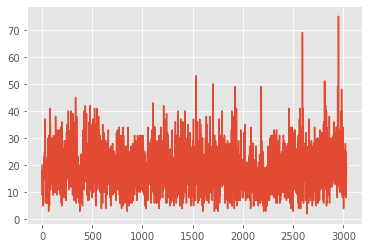

In [ ]:
plt.plot(text_lens)

### Devlopment set

In [ ]:
dev_df = pd.read_csv('./Amharic NER/dev.txt', sep=" ", header='infer', on_bad_lines='skip')
print('Shape of dev data: ', dev_df.shape)

Shape of dev data:  (6878, 2)


In [ ]:
dev_sentences = []
dev_targets = []

x, y = [], []
for idx, row in dev_df.iterrows():
  if row['Text'] in ['!','?','።', '::', '፡፡', '፥']:
    dev_sentences.append(x)
    dev_targets.append(y)
    x, y = [], []
  else:
    x.append(row['Text'].lower())
    y.append(row['Label'])

In [ ]:
dev_dataset = Dataset.from_pandas(pd.DataFrame({'text': dev_sentences, 'label': dev_targets}))

In [ ]:
text_lens = list(map(lambda x: len(x), dev_dataset['text']))

In [ ]:
np.median(text_lens), np.mean(text_lens), np.quantile(text_lens, 0.99)

(16.0, 17.341333333333335, 37.0)

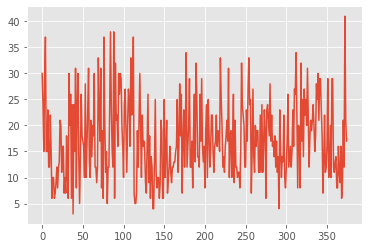

In [ ]:
plt.plot(text_lens)

### Test set

In [ ]:
test_df = pd.read_csv('./Amharic NER/test.txt', sep=" ", header='infer', on_bad_lines='skip')
print('Shape of test data: ', test_df.shape)

Shape of test data:  (6922, 2)


In [ ]:
test_sentences = []
test_targets = []

x, y = [], []
for idx, row in test_df.iterrows():
  if row['Text'] in ['!','?','።','::','፡፡','፥']:
    test_sentences.append(x)
    test_targets.append(y)
    x, y = [], []
  else:
    x.append(row['Text'].lower())
    y.append(row['Label'])

In [ ]:
test_dataset = Dataset.from_pandas(pd.DataFrame({'text': test_sentences, 'label': test_targets}))

In [ ]:
dataset_dict = {
    'train': train_dataset,
    'dev': dev_dataset,
    'test': test_dataset
}

In [ ]:
dataset = DatasetDict(dataset_dict)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3032
    })
    dev: Dataset({
        features: ['text', 'label'],
        num_rows: 375
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 356
    })
})


## Tokenization and Alignment

Get the labels from the training dataframe.

In [ ]:
print("dataset text: ", dataset["train"][0]["text"])

ner_feature = ClassLabel(num_classes=len(train_df['Label'].unique()), names=train_df['Label'].unique())
print("ner_feature: ", ner_feature)

label_names = ner_feature.names
print("label_names: ", label_names)

words = dataset["train"][0]["text"]
labels = dataset["train"][0]["label"]

dataset text:  ['ገለ', 'መሰኻኽር', 'ሓያሎ', 'ጠያይት', 'ክትኮስ', 'ከምዝሰምዑ', 'ክገለጹ', 'እንከለዉ', 'ሓደ', 'ናይ', 'ዓይኒ', 'ምስክር', 'ድማ', 'ኦቶማቲክ', 'ብረት', 'ዝሓዘ', 'ሰብ', 'ክትኩስ', 'ከምዝራኣየ', 'ተዛሪቡ']
ner_feature:  ClassLabel(num_classes=9, names=array(['O', 'B-LOC', 'B-PER', 'I-PER', 'B-DATE', 'I-DATE', 'B-ORG',
       'I-LOC', 'I-ORG'], dtype=object), id=None)
label_names:  ['O' 'B-LOC' 'B-PER' 'I-PER' 'B-DATE' 'I-DATE' 'B-ORG' 'I-LOC' 'I-ORG']


In [ ]:
id2label = {str(i): label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

In [ ]:
line1 = ""
line2 = ""
for word, label in zip(words, labels):
  full_label = label
  max_length = max(len(word), len(full_label))
  line1 += word + " " * (max_length - len(word) + 1)
  line2 += full_label + " " * (max_length - len(full_label) + 1)

print("line1: ", line1)
print("line2: ", line2)

line1:  ገለ መሰኻኽር ሓያሎ ጠያይት ክትኮስ ከምዝሰምዑ ክገለጹ እንከለዉ ሓደ ናይ ዓይኒ ምስክር ድማ ኦቶማቲክ ብረት ዝሓዘ ሰብ ክትኩስ ከምዝራኣየ ተዛሪቡ 
line2:  O  O     O   O    O    O      O    O     O  O  O   O    O  O     O   O   O  O    O      O    


Load tokenizer from Huggingface.

In [ ]:
model_checkpoint = "mbeukman/xlm-roberta-base-finetuned-ner-amharic"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

print("tokenizer.is_fast: ", tokenizer.is_fast)

Downloading:   0%|          | 0.00/398 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.is_fast:  True


In [ ]:
inputs = tokenizer(dataset["train"][0]["text"], is_split_into_words=True)
print("inputs.tokens: ", inputs.tokens())

print("inputs.word_ids: ", inputs.word_ids())

inputs.tokens:  ['<s>', '▁', 'ገለ', '▁መሰ', 'ኻ', 'ኽ', 'ር', '▁ሓ', 'ያ', 'ሎ', '▁ጠ', 'ያ', 'ይት', '▁', 'ክት', 'ኮ', 'ስ', '▁ከም', 'ዝ', 'ሰ', 'ም', 'ዑ', '▁ክ', 'ገለጹ', '▁እን', 'ከ', 'ለዉ', '▁ሓ', 'ደ', '▁', 'ናይ', '▁', 'ዓይ', 'ኒ', '▁ምስ', 'ክር', '▁ድ', 'ማ', '▁ኦ', 'ቶ', 'ማ', 'ቲክ', '▁', 'ብረት', '▁ዝ', 'ሓ', 'ዘ', '▁', 'ሰብ', '▁', 'ክት', 'ኩ', 'ስ', '▁ከም', 'ዝ', 'ራ', 'ኣ', 'የ', '▁ተ', 'ዛ', 'ሪ', 'ቡ', '</s>']
inputs.word_ids:  [None, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 8, 8, 9, 9, 10, 10, 10, 11, 11, 12, 12, 13, 13, 13, 13, 14, 14, 15, 15, 15, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, None]


Utility function to align labels with the word ids.

In [ ]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else ner_feature.str2int(labels[word_id])
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = ner_feature.str2int(labels[word_id])
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [ ]:
labels = dataset["train"][0]["label"]
word_ids = inputs.word_ids()
print("labels: ", labels)
print("Aligned labels: ", align_labels_with_tokens(labels, word_ids))

labels:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Aligned labels:  [-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]


In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["text"], truncation=True, is_split_into_words=True, max_length=max_len
    )
    all_labels = examples["label"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [ ]:
tokenized_datasets = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset["train"].column_names,
)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

batch = data_collator([tokenized_datasets["train"][i] for i in range(2)])
print("Collated batch labels: ", batch["labels"])

Collated batch labels:  tensor([[-100,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0, -100],
        [-100,    0,    0,    0,    0,    1,    2,    2,    2,    2,    2,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0, -100]])


In [ ]:
for i in range(2):
    print(tokenized_datasets["train"][i]["labels"])

[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]
[-100, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]


## Metric initialization

For training

In [ ]:
metric = load_metric("seqeval")

labels = dataset["train"][1000]["label"]
print("labels: ", labels)

labels:  ['O', 'B-LOC', 'I-LOC', 'I-LOC', 'O', 'B-PER', 'I-PER', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
predictions = labels.copy()
predictions[2] = "O"
print(metric.compute(predictions=[predictions], references=[labels]))

{'LOC': {'precision': 0.3333333333333333, 'recall': 0.5, 'f1': 0.4, 'number': 2}, 'PER': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1}, 'overall_precision': 0.5, 'overall_recall': 0.6666666666666666, 'overall_f1': 0.5714285714285715, 'overall_accuracy': 0.96}


In [ ]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

For prediction

In [ ]:
from seqeval import metrics
print(metrics.classification_report([labels], [predictions]))

              precision    recall  f1-score   support

         LOC       0.33      0.50      0.40         2
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.67      0.57         3
   macro avg       0.67      0.75      0.70         3
weighted avg       0.56      0.67      0.60         3



In [ ]:
print(sklearn.metrics.classification_report(labels, predictions))

              precision    recall  f1-score   support

       B-LOC       1.00      1.00      1.00         2
       B-PER       1.00      1.00      1.00         1
       I-LOC       1.00      0.50      0.67         2
       I-PER       1.00      1.00      1.00         1
           O       0.95      1.00      0.97        19

    accuracy                           0.96        25
   macro avg       0.99      0.90      0.93        25
weighted avg       0.96      0.96      0.95        25



## Implementation 1: Training using Trainer API

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

print(model.config.num_labels)

loading configuration file https://huggingface.co/mbeukman/xlm-roberta-base-finetuned-ner-amharic/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/927fe1c2ab3d3fb54d2c5aa32f819999b9f7dd5d6c27845c380c40b60f58b3c8.693635a894aa0fd4c5568f38f8383515f592f3150a916279828282a1f701ea12
Model config XLMRobertaConfig {
  "_name_or_path": "mbeukman/xlm-roberta-base-finetuned-ner-amharic",
  "architectures": [
    "XLMRobertaForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-LOC",
    "2": "I-LOC",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-DATE",
    "6": "I-DATE",
    "7": "B-PER",
    "8": "I-PER"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-DATE": "5",
    "B-LOC": "1",
    "B-ORG": "3",
    "B-PER": "7",
    "I-DATE": 

9


### Training and Evaluation

In [ ]:
args = TrainingArguments(
    "bert-finetuned-ner",
    evaluation_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["dev"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
training_log = trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1702
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1065


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.465520,0.638243,0.753049,0.690909,0.935166
2,No log,0.465674,0.662953,0.725610,0.692868,0.941370
3,0.071400,0.441439,0.694444,0.762195,0.726744,0.946114
4,0.071400,0.480848,0.687324,0.743902,0.714495,0.941126
5,0.002400,0.483663,0.687151,0.750000,0.717201,0.942586


***** Running Evaluation *****
  Num examples = 245
  Batch size = 8
***** Running Evaluation *****
  Num examples = 245
  Batch size = 8
***** Running Evaluation *****
  Num examples = 245
  Batch size = 8
***** Running Evaluation *****
  Num examples = 245
  Batch size = 8
***** Running Evaluation *****
  Num examples = 245
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




### Prediction

In [ ]:
predictions = trainer.predict(tokenized_datasets["test"])

***** Running Prediction *****
  Num examples = 489
  Batch size = 8


In [ ]:
predictions.metrics

{'test_accuracy': 0.9360296892690905,
 'test_f1': 0.6751054852320676,
 'test_loss': 0.5242647528648376,
 'test_precision': 0.6379585326953748,
 'test_recall': 0.7168458781362007,
 'test_runtime': 2.3551,
 'test_samples_per_second': 207.634,
 'test_steps_per_second': 26.326}

In [ ]:
preds = predictions.predictions.argmax(-1)
labels = tokenized_datasets["test"]['labels']

In [ ]:
def postprocess(predictions, labels):

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_labels, true_predictions

In [ ]:
y_true, y_pred = [], []
true_predictions, true_labels = postprocess(preds, labels)

y_true +=  [tag for entry in true_labels for tag in entry]
y_pred +=  [tag for entry in true_predictions for tag in entry]

In [ ]:
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      B-DATE       0.86      0.81      0.83       113
       B-LOC       0.82      0.79      0.81       235
       B-ORG       0.60      0.53      0.56        94
       B-PER       0.83      0.82      0.83       144
      I-DATE       0.82      0.88      0.85       370
       I-LOC       0.84      0.68      0.75       704
       I-ORG       0.61      0.56      0.59       430
       I-PER       0.86      0.80      0.83       615
           O       0.96      0.98      0.97     13193

    accuracy                           0.94     15898
   macro avg       0.80      0.76      0.78     15898
weighted avg       0.93      0.94      0.93     15898



## Implementation 2: Training using custom training loop

In [ ]:
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)
eval_dataloader = DataLoader(
    tokenized_datasets["dev"], collate_fn=data_collator, batch_size=8
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], collate_fn=data_collator, batch_size=1
)

In [ ]:
def postprocess(predictions, labels):
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_labels, true_predictions

### Model Initialize

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Downloading:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
accelerator = Accelerator()

model, optimizer, train_dataloader, eval_dataloader, test_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader, test_dataloader
)

In [ ]:
num_train_epochs = 10
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

### Training and Evaluation

In [ ]:
train_losses, result_list = [], []
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        train_losses.append(loss)
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    loss = 0
    for batch in eval_dataloader:
        with torch.no_grad():
            outputs = model(**batch)
            loss += outputs.loss
        
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]

        # Necessary to pad predictions and labels for being gathered
        predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

        predictions_gathered = accelerator.gather(predictions)
        labels_gathered = accelerator.gather(labels)

        true_predictions, true_labels = postprocess(predictions_gathered, labels_gathered)
        metric.add_batch(predictions=true_predictions, references=true_labels)
    

    results = metric.compute()
    result_list.append(results)
    print(
        f"epoch {epoch}:",
        {
            key: results[f"overall_{key}"]
            for key in ["precision", "recall", "f1", "accuracy"]
        },
    )

  0%|          | 0/3790 [00:00<?, ?it/s]

epoch 0: {'precision': 0.6325724319578577, 'recall': 0.6508581752484192, 'f1': 0.6415850400712377, 'accuracy': 0.8874156958920908}
epoch 1: {'precision': 0.7449517120280948, 'recall': 0.6949221949221949, 'f1': 0.7190677966101695, 'accuracy': 0.9051961986511343}
epoch 2: {'precision': 0.7497805092186128, 'recall': 0.7799086757990867, 'f1': 0.7645478961504029, 'accuracy': 0.9208307786633967}
epoch 3: {'precision': 0.810359964881475, 'recall': 0.7637567232105916, 'f1': 0.7863684771033014, 'accuracy': 0.9214438994481913}
epoch 4: {'precision': 0.8314310798946444, 'recall': 0.7557861133280128, 'f1': 0.7918060200668896, 'accuracy': 0.9215971796443899}
epoch 5: {'precision': 0.8446005267778753, 'recall': 0.7173750932140194, 'f1': 0.7758064516129033, 'accuracy': 0.9143930104230533}
epoch 6: {'precision': 0.8331870061457419, 'recall': 0.7862468931234465, 'f1': 0.8090366581415175, 'accuracy': 0.930793991416309}
epoch 7: {'precision': 0.8292361720807726, 'recall': 0.7799339388934765, 'f1': 0.8038

### Save/Load Model

In [ ]:
# Save
model.save_pretrained('./Amharic NER/finetuned_XLM_Roberta/')

In [ ]:
# Load
model = AutoModelForTokenClassification.from_pretrained('./Amharic NER/finetuned_XLM_Roberta/')

### Prediction

#### Single Instance

In [ ]:
test_instance = next(iter(test_dataloader))
while True:
  instance = next(iter(test_dataloader))
  unique_labels = set(instance['labels'].tolist()[0])
  if len(unique_labels) > 4:
    test_instance = instance
    break

outputs = model(**test_instance)

In [ ]:
predictions = outputs.logits.argmax(dim=-1)
labels = test_instance["labels"]

# Necessary to pad predictions and labels for being gathered
predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

predictions_gathered = accelerator.gather(predictions)
labels_gathered = accelerator.gather(labels)

true_predictions, true_labels = postprocess(predictions_gathered, labels_gathered)

In [ ]:
for i, j, k in zip(test_instance['input_ids'].tolist()[0], true_predictions[0], true_labels[0]):
  print(f'{tokenizer.decode(i)}\t\t{j}\t\t{k}')

<s>		O		O
ኣብ		O		B-DATE
እ		O		B-DATE
ዋን		O		O
ም		O		O
ም		O		O
ሕ		O		O
ዳር		B-PER		B-PER
		B-PER		B-PER
በራ		B-PER		B-PER
ክ		I-PER		I-PER
ኦ		B-DATE		B-DATE
ባ		B-DATE		B-DATE
ማ		O		O
ኣብ		O		O
ጉዳ		O		O
ያት		O		O
ፖሊሲ		O		O
ወ		O		O
ጻ		O		O
ኢ		O		O
ዝ		O		O
ነ		O		O
ጠ		O		O
ፉ		B-PER		B-PER
		B-PER		B-PER
ቤ		B-PER		B-PER
ን		I-PER		I-PER
		B-DATE		B-DATE
ሮ		B-DATE		B-DATE
ድ		O		O
ብ		O		O
ወ		O		O
ገ		O		O
ኖ		O		O
ም		O		O
ኣብ		B-LOC		B-LOC
ኢትዮጵያ		O		O


#### All Instances

In [ ]:
# Prediction

y_true = []
y_pred = []

model.eval()
for batch in test_dataloader:

  with torch.no_grad():
    outputs = model(**batch)

  predictions = outputs.logits.argmax(dim=-1)
  labels = batch["labels"]

  # Necessary to pad predictions and labels for being gathered
  predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
  labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

  predictions_gathered = accelerator.gather(predictions)
  labels_gathered = accelerator.gather(labels)

  true_predictions, true_labels = postprocess(predictions_gathered, labels_gathered)

  y_true +=  [tag for entry in true_labels for tag in entry]
  y_pred +=  [tag for entry in true_predictions for tag in entry]

### Result Analysis

#### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels=label_names)

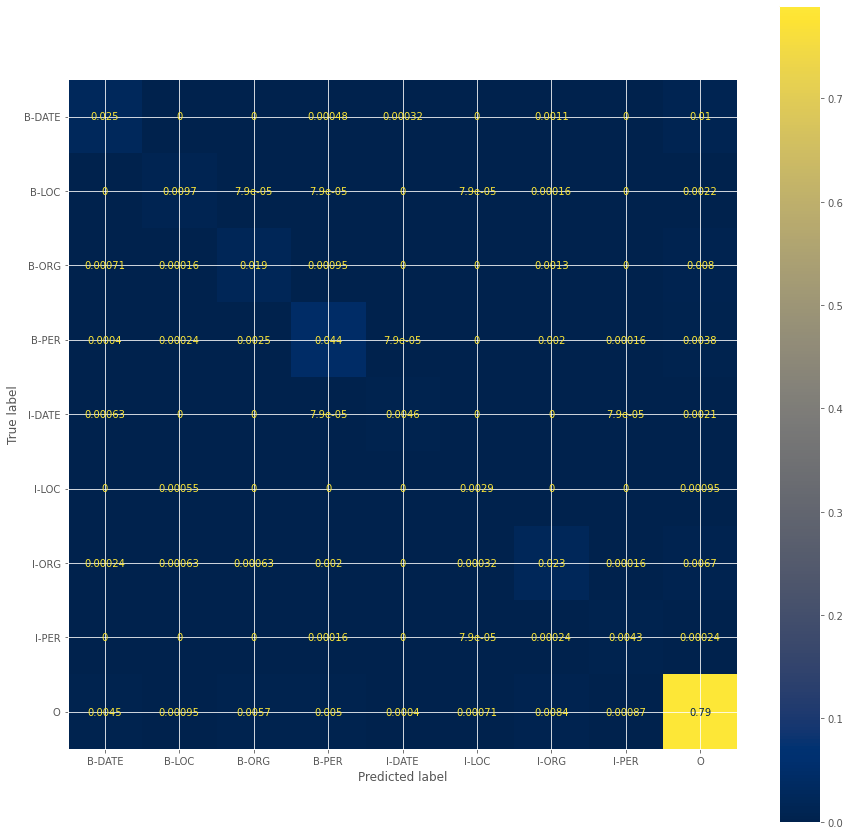

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax, cmap='cividis', normalize='all')
plt.show()

In [ ]:
cm

array([[9960,   12,   63,   11,   57,    5,   72,    9,  106],
       [  28,  123,    1,    0,    0,    0,    1,    1,    2],
       [  48,    3,  558,    2,    5,    1,   32,    0,   25],
       [   3,    0,    2,   54,    0,    0,    0,    1,    3],
       [ 131,    0,    6,    0,  317,    4,    0,    0,   14],
       [  26,    0,    1,    1,    8,   58,    0,    0,    0],
       [ 101,    2,   12,    0,    9,    0,  246,    0,   16],
       [  12,    7,    0,    0,    0,    0,    0,   36,    0],
       [  84,    8,   25,    2,    3,    0,    8,    4,  295]])

#### Classification report

In [ ]:
print(metrics.classification_report([y_true], [y_pred]))

              precision    recall  f1-score   support

        DATE       0.78      0.65      0.71       488
         LOC       0.81      0.79      0.80       196
         ORG       0.66      0.60      0.63       446
         PER       0.82      0.82      0.82       680

   micro avg       0.77      0.72      0.74      1810
   macro avg       0.77      0.71      0.74      1810
weighted avg       0.77      0.72      0.74      1810



In [ ]:
print(sklearn.metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      B-DATE       0.79      0.67      0.73       472
       B-LOC       0.79      0.79      0.79       156
       B-ORG       0.69      0.64      0.66       386
       B-PER       0.84      0.83      0.83       674
      I-DATE       0.85      0.62      0.72        94
       I-LOC       0.71      0.65      0.68        55
       I-ORG       0.64      0.69      0.66       429
       I-PER       0.77      0.86      0.81        63
           O       0.96      0.97      0.96     10295

    accuracy                           0.92     12624
   macro avg       0.78      0.75      0.76     12624
weighted avg       0.92      0.92      0.92     12624



#### Plots

In [ ]:
loss_history = [loss.detach().cpu().clone().numpy() for loss in train_losses]

In [ ]:
def plot_graph(value_list, title, x_label, y_label):
  plt.plot(value_list)
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.show()

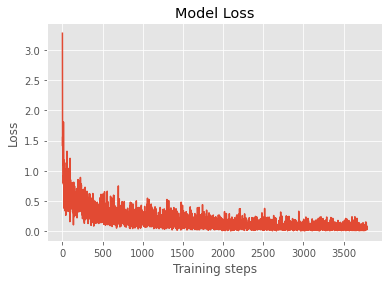

In [ ]:
plot_graph(loss_history, 'Model Loss', 'Training steps', 'Loss')

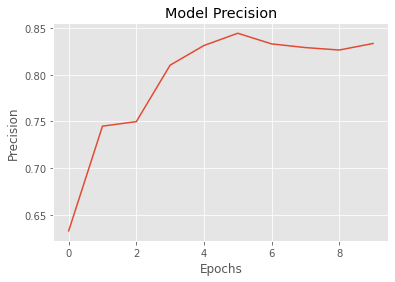

In [ ]:
plot_graph(list(map(lambda x: x['overall_precision'], result_list)), 'Model Precision', 'Epochs', 'Precision')

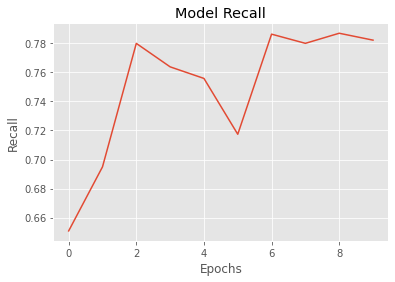

In [ ]:
plot_graph(list(map(lambda x: x['overall_recall'], result_list)), 'Model Recall', 'Epochs', 'Recall')

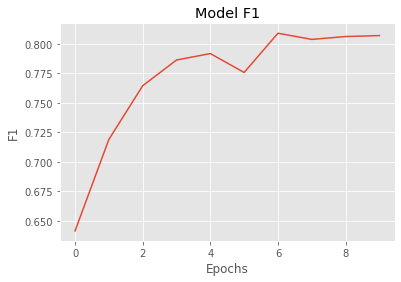

In [ ]:
plot_graph(list(map(lambda x: x['overall_f1'], result_list)), 'Model F1', 'Epochs', 'F1')

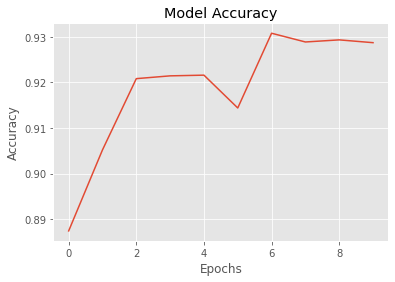

In [ ]:
plot_graph(list(map(lambda x: x['overall_accuracy'], result_list)), 'Model Accuracy', 'Epochs', 'Accuracy')